In [21]:
import numpy as np
import nengo
import nengo_spa as spa  # Tutorial completed in nengo_spa, not legacy spa!
import matplotlib.pyplot as plt

rng = np.random.RandomState(1) # random number generator

In [41]:
d = 32
vocab = spa.Vocabulary(d, pointer_gen=rng)

# Adding semantic pointers to the vocabulary
vocab.populate("CIRCLE; SQUARE; BLUE; RED; STATEMENT; QUESTION")

with spa.Network(label="Question Answering with Control", vocabs=[vocab]) as model:
    visual = spa.State(d)
    motor = spa.State(d)
    memory = spa.State(d)

    with spa.ActionSelection() as action_sel:
        spa.ifmax(spa.dot(spa.sym.STATEMENT, visual),
            visual >> memory)
        spa.ifmax(spa.dot(spa.sym.QUESTION, visual),
            memory * ~visual >> motor)

    # i thought there is no need for a thalamus and basal ganglia but then motor is dead
    p_thalamus = nengo.Probe(action_sel.thalamus.output, synapse=0.01,label='thalamus')
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01,label='utility')

    # Function for providing visual input
    def visual_input(t):
        if 0.1 < t < 0.3:
            return "STATEMENT+RED*CIRCLE"
        elif 0.35 < t < 0.5:
            return "STATEMENT+BLUE*SQUARE"
        elif 0.55 < t < 0.7:
            return "QUESTION+BLUE"
        elif 0.75 < t < 0.9:
            return "QUESTION+CIRCLE"
        return spa.semantic_pointer.Zero(d)

    # Input
    spa.Transcode(visual_input,output_vocab=vocab) >> visual

    # Probes
    pVisual = nengo.Probe(visual.output,synapse=0.01,label='visual')
    pMemory = nengo.Probe(memory.output,synapse=0.01,label='memory')
    pMotor = nengo.Probe(motor.output,synapse=0.01,label='motor')

/Users/beep/PycharmProjects/nengoPlayground/venv/lib/python3.8/site-packages/nengo_spa/modules/basalganglia.py:174: UserWarning: SciPy is not installed, so BasalGanglia will use the default decoder solver. Installing SciPy may improve BasalGanglia performance.
  warnings.warn(


In [42]:
with nengo.Simulator(model) as sim:
    sim.run(1.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/Users/beep/PycharmProjects/nengoPlayground/venv/lib/python3.8/site-packages/nengo/builder/optimizer.py:654: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

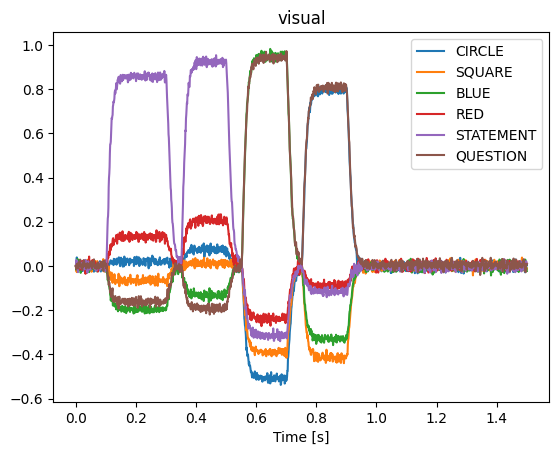

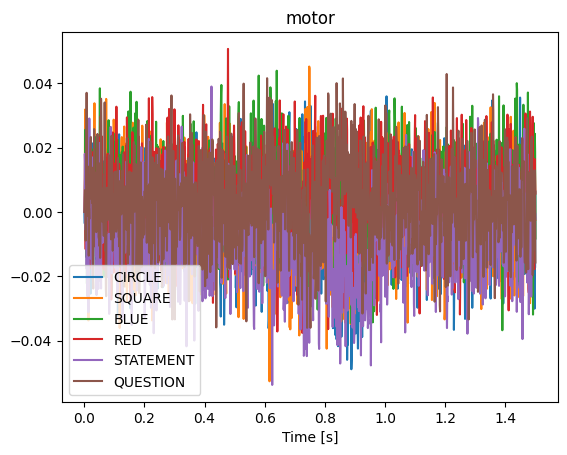

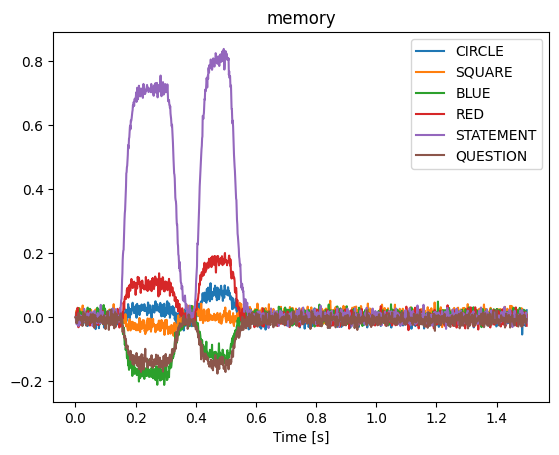

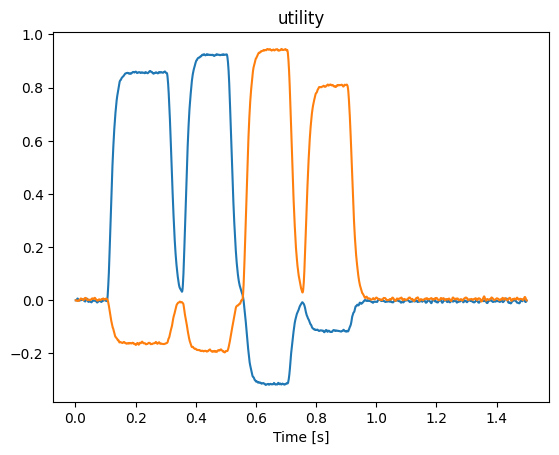

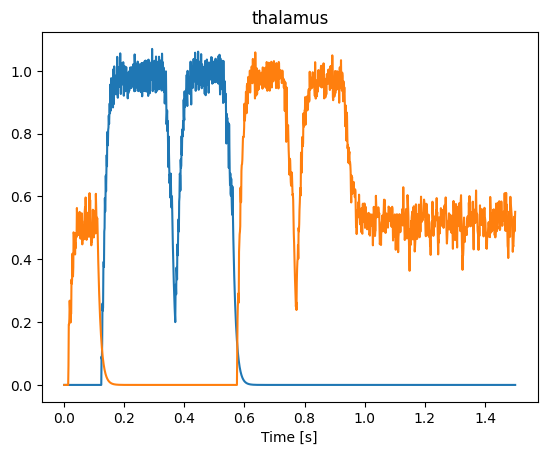

In [43]:
for probe in [pVisual,pMotor,pMemory]:
    plt.plot(sim.trange(), spa.similarity(sim.data[probe], vocab))
    plt.xlabel("Time [s]")
    plt.legend(vocab, loc="best")
    plt.title(probe.label)
    plt.show()
for probe in [p_utility,p_thalamus]:
    plt.plot(sim.trange(), sim.data[probe])
    plt.xlabel("Time [s]")
    plt.title(probe.label)
    plt.show()

In [38]:
sim.data[p_thalamus]

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       ...,
       [1.37021280e-41, 4.61624617e-01],
       [1.23981981e-41, 5.15083672e-01],
       [1.12183535e-41, 4.66655380e-01]])

In [34]:
sim.trange().shape

(1500,)

In [40]:
sim.data[pMotor].shape

(1500, 32)